# Massively parallel ML assisted transition path sampling from equilibrium shooting points

## Notebook 3: Continue and analyze TPS simulation

This is the third of a series of example notebooks on massively parallel transition path sampling (TPS) using shooting points with a known equilibrium weight. If you have not done so, please have a look at and run the first and second notebooks of the series, they must be run before this one.

In this notebook we will see how we could extend the TPS simulation starting from the last state in the previous notebook, but mainly we will analyze the simulation results. To this end we will have a look at the reaction coordinate model training during the simulation, perform a relative input importance analysis and then look at some key quantities of the transition path ensemble. Namely we will look at the density of transition paths and shooting points in the $\psi$, $\phi$ plane and the transition path time distribution.

**This notebook should be run on a multi-core workstation preferably with a GPU**, otherwise you will have a very long coffee break and a very hot laptop.

**Required knowledge/recommended reading:** This notebooks assumes some familarity with the `asyncmd` (namely the [gromacs] engine and TrajectoryFunctionWrapper classes). Please see the example notebooks in `asyncmd` for an introduction.

## Imports and set working directory

In [1]:
%matplotlib inline

In [2]:
import os
import asyncio
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as mdt
import MDAnalysis as mda
import aimmd
import aimmd.distributed as aimmdd
import asyncmd
import asyncmd.trajectory as asynctraj
import asyncmd.gromacs as asyncgmx
from asyncmd import Trajectory

/home/think/.conda/envs/aimmd_dev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not initialize SLURM cluster handling. If you are sure SLURM (sinfo/sacct/etc) is available try calling `asyncmd.config.set_slurm_settings()` with the appropriate arguments.
Tensorflow/Keras not available


In [3]:
# setup working directory (this should be the same as in the previous notebook)

scratch_dir = "/home/think/scratch/aimmd_distributed/"
#scratch_dir = "."

workdir = os.path.join(scratch_dir, "PathSampling_from_EQ_mda_test")

## Continue TPS simulation

To continue the TPS simulation we need to:
 - open the storage file from last time
 - load the reaction coodrinate model and trainset from it
 - redefine the brain tasks using the storage, reaction coordinate model and trainset
 - and finaly load the brain using the reaction coodrinate model and tasks

The loaded brain will then be exactly in the state we left it at the end of the last notebook.

### Open the storage (in append mode)

In [8]:
storage = aimmd.Storage(os.path.join(workdir, "storage.h5"), mode="a")

### Load the model

In [9]:
model = storage.rcmodels["model_to_continue_with"]

### Load the trainset

In [10]:
trainset = storage.load_trainset()

### Redefine the brain tasks

In [12]:
from state_funcs_mda import descriptor_func_psi_phi

wrapped_psi_phi = asyncmd.trajectory.PyTrajectoryFunctionWrapper(descriptor_func_psi_phi)

In [13]:
# define the US trajectory and calculate weights for eq
path_to_us = "/home/think/scratch/aimmd_distributed/UmbrellaSampling"

us_traj = asyncmd.Trajectory(structure_file=os.path.join(path_to_us, "US.tpr"),
                             trajectory_files=os.path.join(path_to_us, "US.part0001.xtc"))
us_mdp = asyncgmx.MDP(os.path.join(path_to_us, "US.mdp"))

psi_phi_us = await wrapped_psi_phi(us_traj)

# now get the weights
from scipy import constants

# read the values for force constant and potential zero point directly from the umbrella sampling mdp
T = us_mdp["ref-t"][0]
k_psi = float(us_mdp["pull-coord1-k"][0]) # kJ/ (mol * rad**2)
psi_0 = float(us_mdp["pull-coord1-init"][0]) * np.pi / 180  # psi_0 in rad
try:
    # make sure we do not crash if we biased only along ψ (and not also along φ)
    k_phi = float(us_mdp["pull-coord2-k"][0]) # kJ/ (mol * rad**2)
    phi_0 = float(us_mdp["pull-coord2-init"][0]) * np.pi / 180  # psi_0 in rad
except KeyError:
    k_phi = 0
    phi_0 = 0

# Note that gromacs uses the conventions:
#      U_bias = k/2 (x - x0)**2
#      F_bias = - k (x - x0)

def U_bias(x, x_0, k):
    return (k / 2) * (x - x_0) * (x - x_0)

beta = 1000 / (constants.R * T)  # beta in kJ /mol

weights = np.exp(beta * ( U_bias(psi_phi_us[:, 0], psi_0, k_psi) + U_bias(psi_phi_us[:, 1], phi_0, k_phi) ))

In [14]:
tasks = [aimmdd.pathsampling.TrainingTask(model=model, trainset=trainset),
         aimmdd.pathsampling.SaveTask(storage=storage, model=model, trainset=trainset),
         aimmdd.pathsampling.DensityCollectionTask(model=model,
                                                   first_collection=0,
                                                   recreate_interval=50,
                                                   mode="custom",
                                                   trajectories=[us_traj],
                                                   trajectory_weights=[weights],
                                                   interval=10
                                                   ),
         ]

### Load the brain

In [15]:
brain = storage.load_brain(model=model, tasks=tasks)

In [16]:
brain.total_steps

10011

### Run for a couple of steps

In [17]:
# now we could continue where we stopped the sampling last time
# so we do 10 steps just to prove that it works
await brain.run_for_n_steps(10)

In [18]:
brain.total_steps

10011

### Save the last model, trainset and brain

Better save it now before we forget about it after the analysis...

In [ ]:
# save the new model, trainset and brain state
storage.rcmodels["model_to_continue_with"] = model
storage.save_trainset(trainset)
storage.save_brain(brain)

## Plot the training of the model during the simulation

### Learning rate vs Monte Carlo step

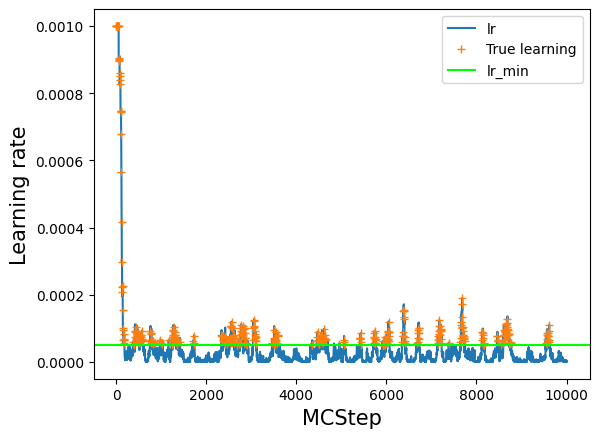

In [23]:
# lets have a look at the value of the learning rate over the course of training
# note however, that we did not train at every step, but just at every interval MCsteps
log_train = np.array(model.log_train_decision)
lr = log_train[:,1]
plt.plot(lr, label='lr')
# see where we really trained: everywhere where train=True
# set lr_true to NaN anywhere where we did not train to have a nice plot
lr_true = lr
lr_true[log_train[:,0] == False] = np.nan
plt.plot(lr_true, '+', label='True learning')
# lr_min as a guide to the eye
plt.axhline(model.ee_params['lr_min'], label='lr_min', color='lime')
plt.legend()
plt.xlabel('MCStep', size=15);
plt.ylabel('Learning rate', size=15);

### Loss vs Monte Carlo step

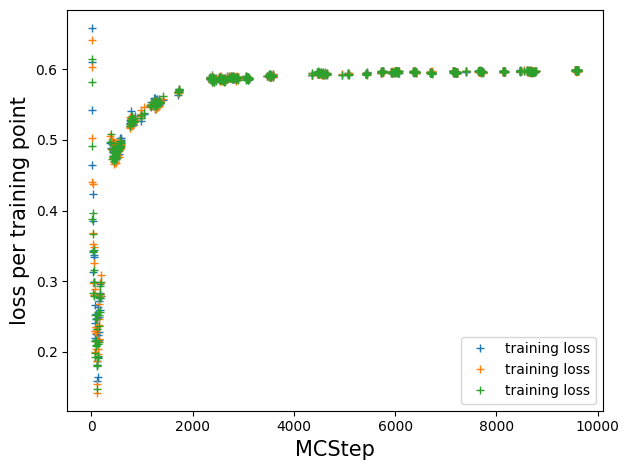

In [25]:
# resort such that we have a loss value per MCStep, NaN if we did not train at that step
train_loss = []
count = 0
for t in log_train[:, 0]:
    if t:
        train_loss.append(model.log_train_loss[count])
        count += 1
    else:
        train_loss.append([np.nan for _ in range(model.ee_params['epochs_per_train'])])
    
plt.plot(train_loss, '+', label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('MCStep', size=15)
plt.tight_layout()

### Cumulative counts of expected, generated transitions vs Monte Carlo step

Note that it does not really make sense to plot accepts, as every step is an accepted step when shooting from SPs with know equilibrium weight. Here only the (ensemble) weight of the transition matters.

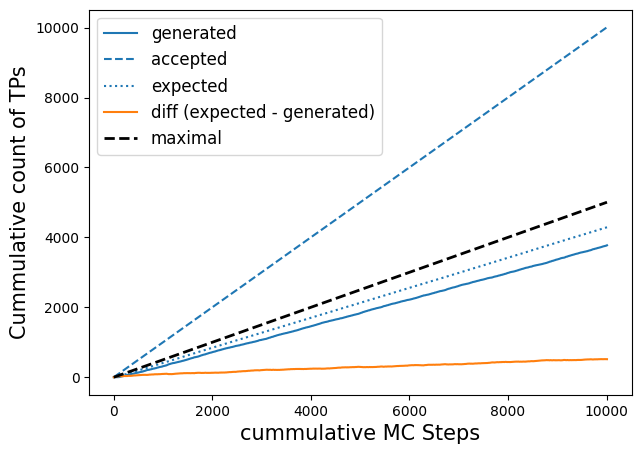

In [30]:
# plot efficiency, expected efficiency
# Note: this will only work for models with n_out=1, due to the way we calculate p(TP|x)
fig, axs = plt.subplots(figsize=(7, 5))

n_steps = -1  # up to which step number to plot

p_ex = np.array(model.expected_p)[:n_steps]

l, = axs.plot(np.cumsum(trainset.transitions[:n_steps]), label='generated');
axs.plot(np.cumsum(2*p_ex*(1 - p_ex)),c=l.get_color(), ls=':', label='expected');
axs.plot(np.cumsum(2*p_ex*(1 - p_ex))- np.cumsum(trainset.transitions[:n_steps]), label='diff (expected - generated)')
axs.plot(np.linspace(0., len(trainset[:n_steps])/2., len(trainset[:n_steps])), c='k', ls='--', label='maximal', lw=2)
axs.legend(fontsize=12);
axs.set_ylabel('Cummulative count of TPs', size=15)
axs.set_xlabel('cummulative MC Steps', size=15);

## Relative input importance analysis

We will use the hipr class to perform the input importance analysis, it randomizes each coordinate one at a time and calculates the resulting losses.

In [27]:
hipr = aimmd.analysis.HIPRanalysis(model, trainset)

In [28]:
hipr_plus_losses, hipr_plus_stds = hipr.do_hipr_plus(25)

### Plot the loss increase (relative importance) for each coordinate by index

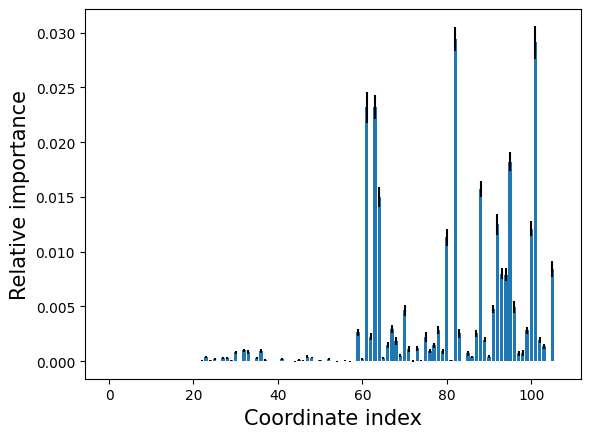

In [29]:
loss_diffs = hipr_plus_losses[:-1] - hipr_plus_losses[-1]  # hipr_losses[-1] is the reference loss over the unaltered trainset

plt.bar(np.arange(len(loss_diffs)), loss_diffs, yerr=hipr_plus_stds[:-1])
plt.xlabel('Coordinate index', size=15)
plt.ylabel('Relative importance', size=15);

### Print out the most important coordinates

We try our best to print out the most relevant coordinates in a human understandeable form.

In [31]:
# what are the most important contributors?
max_idxs = np.argsort(loss_diffs)[::-1]

# import the function used to generate the internal coordinate representation for the molecule
from state_funcs_mda import generate_atomgroups_for_ic

# and use it to get lists of pairs (distances), triples (angles) and quadruples ([pseudo-]dihedrals)
u = mda.Universe("gmx_infiles/ala_300K_amber99sb-ildn.tpr", "gmx_infiles/conf.gro",
                 refresh_offsets=True, tpr_resid_from_one=True)
molecule = u.select_atoms('protein')
pairs, triples, quadruples = generate_atomgroups_for_ic(molecule)

def pprint_atom(at):
    """Helper function to print atom information in a nice way."""
    ret = f"Atom {at.ix+1}:"
    if hasattr(at, "name"):
        ret += f" {at.name}"
    if hasattr(at, "resname"):
        ret += f" in residue {at.resname}"
    if hasattr(at, "resid"):
        ret += f" (resid {at.resid})"
    return ret

# now use all of this to print the most relevant coordinates in a remotely human understandable fashion
print('reference loss:', hipr_plus_losses[-1])
for idx in max_idxs[:6]:
    print()
    print('loss for idx {:d}: '.format(idx), hipr_plus_losses[idx], f" (loss diff= {hipr_plus_losses[idx] - hipr_plus_losses[-1]})")
    if idx < len(pairs[0]):
        print(f"bond between: {pprint_atom(pairs[0][idx])} and {pprint_atom(pairs[1][idx])}")
        continue
    idx -= len(pairs[0])
    if idx < len(triples[0]):
        print(f"angle between {pprint_atom(triples[0][idx])}, {pprint_atom(triples[1][idx])} and {pprint_atom(triples[2][idx])}")
        continue
    idx -= len(triples[0])
    if idx % 2 == 0:
        st = "sinus"
    else:
        st = "cosinus"
    st += f" of dihedral between {pprint_atom(quadruples[0][idx // 2])}, {pprint_atom(quadruples[1][idx // 2])}, {pprint_atom(quadruples[2][idx // 2])}"
    st += f" and {pprint_atom(quadruples[3][idx // 2])}."
    print(st)

reference loss: 0.5958509604279043

loss for idx 82:  0.625259861613163  (loss diff= 0.02940890118525874)
cosinus of dihedral between Atom 7: N in residue ALA (resid 2), Atom 9: CA in residue ALA (resid 2), Atom 15: C in residue ALA (resid 2) and Atom 17: N in residue NME (resid 3).

loss for idx 101:  0.6249678200658962  (loss diff= 0.029116859637991932)
sinus of dihedral between Atom 14: HB3 in residue ALA (resid 2), Atom 11: CB in residue ALA (resid 2), Atom 9: CA in residue ALA (resid 2) and Atom 15: C in residue ALA (resid 2).

loss for idx 63:  0.6190434286932811  (loss diff= 0.023192468265376798)
sinus of dihedral between Atom 3: HH32 in residue ACE (resid 1), Atom 1: CH3 in residue ACE (resid 1), Atom 5: C in residue ACE (resid 1) and Atom 6: O in residue ACE (resid 1).

loss for idx 61:  0.6190219552437631  (loss diff= 0.023170994815858825)
sinus of dihedral between Atom 2: HH31 in residue ACE (resid 1), Atom 1: CH3 in residue ACE (resid 1), Atom 5: C in residue ACE (resid 1) 

## Analyze the transition path ensemble

We will have a look at the density of transitions and shootin points in the $\psi$, $\phi$ plane and at the transition time distribution. Note that instead of a function projecting the trajectories to the $\psi$, $\phi$ plane, you could use any function that projects configurations to lower dimensional spaces or calculates scalars over whole trajectories (as for the distribution of transition times). To calculate any average you just have to weight the contribution of each transition by its weight.

### Get all transitions and their weights

In [17]:
weights = []
transitions = []

for step in storage.mcstep_collections[0]:  # only one stepcollection as all sampler go into the same...because they have weights
    if step.weight > 0:
        # only keep steps with weight > 0, only these will have transitions (and contribute to the TPE)
        weights += [step.weight]
        transitions += [step.path]

### Plot the histogram of all weigths

Text(0, 0.5, 'Count')

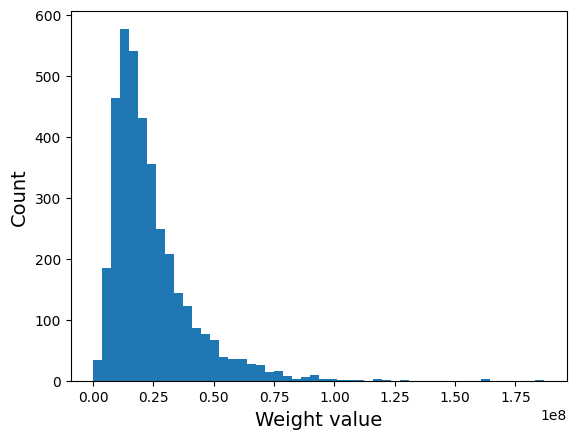

In [18]:
fig, axs = plt.subplots()

axs.hist(weights, bins=50);
axs.set_xlabel("Weight value", size=14)
axs.set_ylabel("Count", size=14)

### Plot transition path time distribution

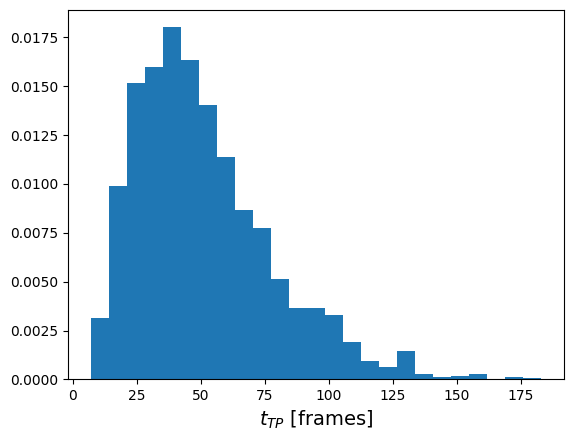

In [24]:
fig, axs = plt.subplots()

t_TP_in_frames = [len(tp) for tp in transitions]

axs.hist(t_TP_in_frames, weights=weights,
         bins=25, density=True)
axs.set_xlabel("$t_{TP}$ [frames]", size=14);

### Plot the density of transitions in the $\psi$, $\phi$ plane, $p(\psi,\phi|TP)$

In [25]:
# calculate psi and phi values for all transitions
transitions_psi_phi = await asyncio.gather(*(wrapped_psi_phi(tp) for tp in transitions))

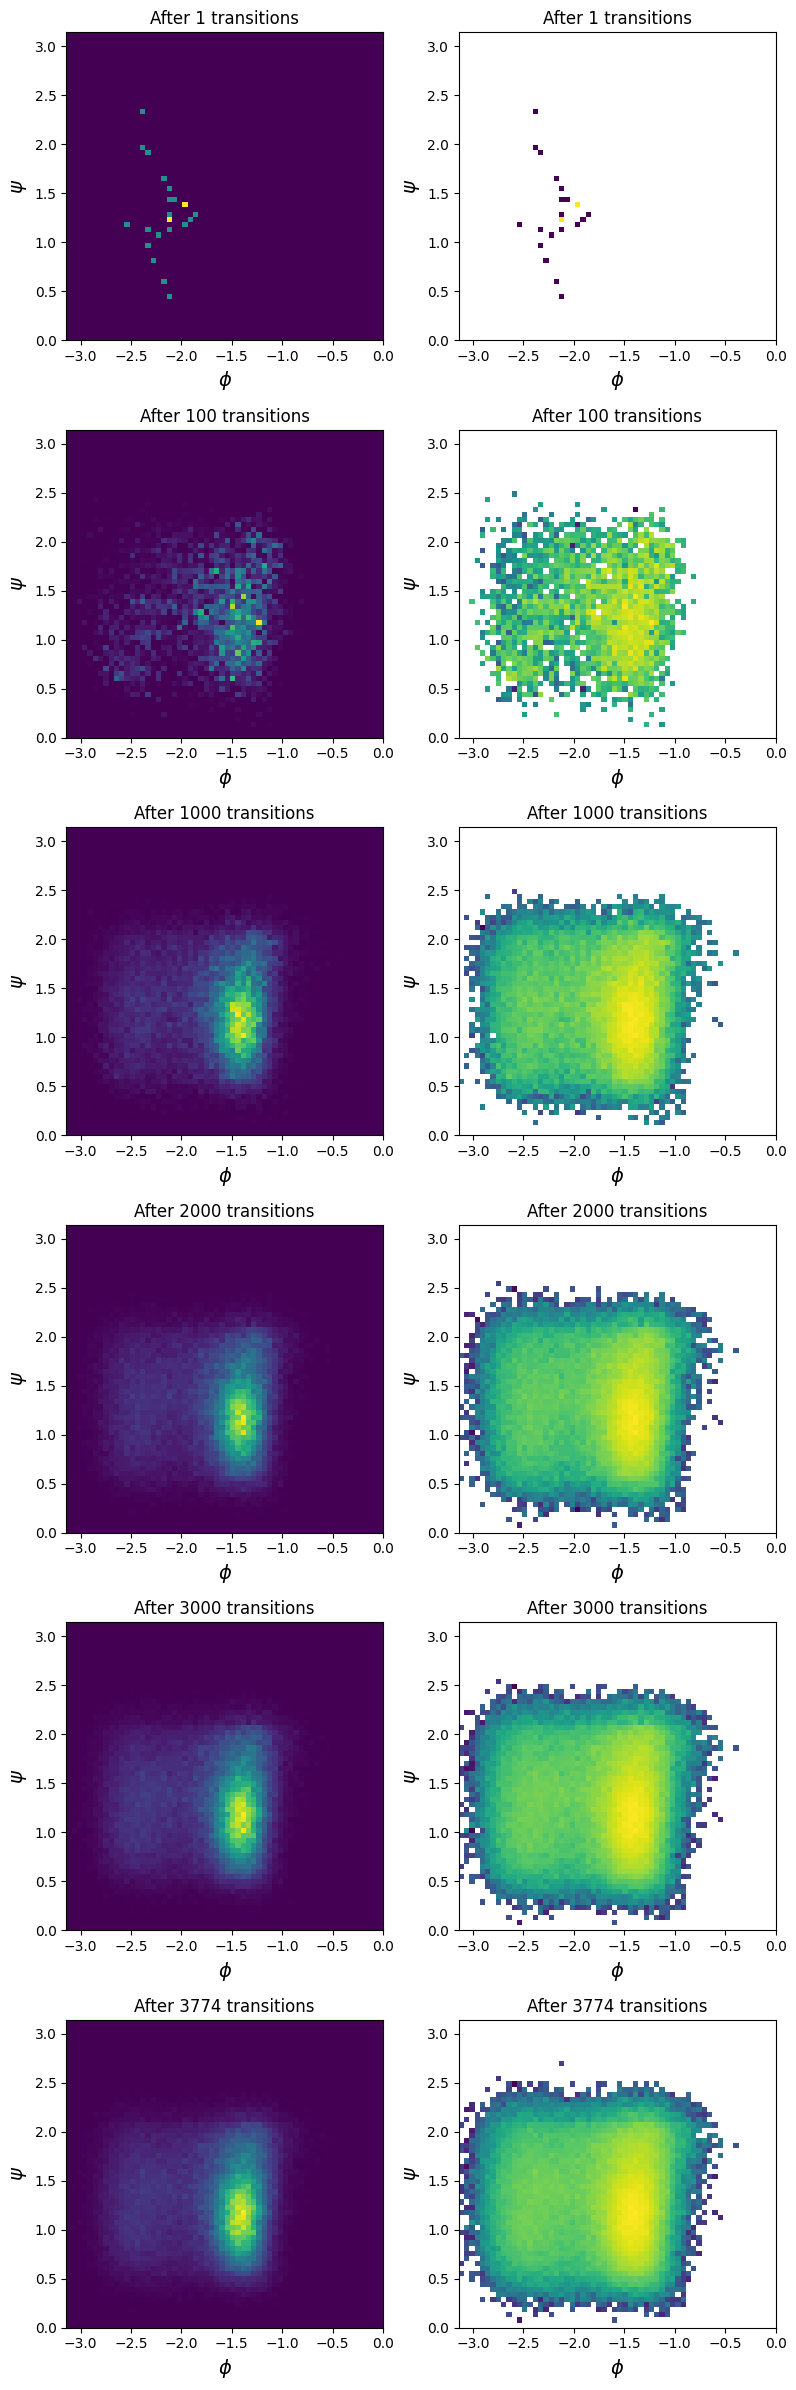

In [26]:
#steps_done = [1, 500, None]  # the None gives us the last step for all chains
steps_done = [1, 100, 1000, 2000, 3000, None]  # the None gives us the last step for all chains


fig, axs = plt.subplots(ncols=2, nrows=len(steps_done),
                        figsize=(8, 4*len(steps_done)))

for max_step, axs_arr in zip(steps_done, axs):
    plot_data = np.concatenate(transitions_psi_phi[:max_step], axis=0)
    ws = np.concatenate([[w for _ in range(len(tp))]
                         for w, tp in zip(weights[:max_step], transitions[:max_step])
                        ], axis=0)
    for i, ax in enumerate(axs_arr):
        ax.set_title(f"After {len(transitions[:max_step])} transitions")
        ax.set_xlabel("$\phi$", size=14)
        ax.set_ylabel("$\psi$", size=14)
        if i == 0:
            ax.hist2d(plot_data[:, 1], plot_data[:, 0], weights=ws, bins=(60, 60), range=((-np.pi, 0), (0, np.pi)), density=True)
        elif i == 1:
            ax.hist2d(plot_data[:, 1], plot_data[:, 0], weights=ws, bins=(60, 60), range=((-np.pi, 0), (0, np.pi)), density=True,
                      norm="log")
        ax.set_xlim(-np.pi, 0)
        ax.set_ylim(0, np.pi)

fig.tight_layout()

In [86]:
storage.close()